# Prédiction modèle

In [300]:
# Importation des modules
import requests  # Connexion à l'API de AlphaVantage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler

In [301]:
# Clé personnelle de l'API AlphaVantage
key_API = 'LYMJQ6KR5QPKJ8W3'
equity = 'IBM'   #choisir n'importe quelle equity

# URL pour obtenir les données hebdomadaires ajustées
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={equity}&apikey={key_API}'
r = requests.get(url)
data = r.json()

# Accès au sous-dictionnaire contenant les données
time_serie = data['Weekly Adjusted Time Series']

# Extraction des données de clôture (4. close) en tant que tableau NumPy
close_values = np.array([float(entry['4. close']) for entry in time_serie.values()])

In [309]:
# Nombre de jours à utiliser pour chaque séquence
sequence_length = 10

# Nombre de jours pour les données d'entraînement
train_size = 1000

# Nombre de jours pour les données d'évaluation
eval_size = 250

# Données d'entrainement 
X_train = []
Y_train = []

#normalisation des données 
scaler = StandardScaler()
close_values = close_values.reshape(-1,1)
Train = close_values[:train_size + 1]
Test = close_values[train_size:train_size + eval_size]

scaler.fit(Train)
scaler.transform(Train)
scaler.transform(Test)

# Créez les séquences d'entraînement
for i in range(train_size - sequence_length):
    seq = []
    target = []

    for k in range(sequence_length):
        seq.append(Train[i + k])  # Séquence de 10 jours

    target.append(Train[i + sequence_length + 1])  # le jour qui suit la séquence
    
    X_train.append(seq)
    Y_train.append(target)


# Maintenant, X_train contient les séquences d'entraînement (990 séquences de 10 jours),
# et Y_train contient les 990 jours suivants correspondant à chaque séquence.

# Données d'évaluation
X_eval = []
Y_eval = []

# Créez les séquences d'évaluation
for i in range(eval_size - sequence_length - 1):
    seq = []
    target = []

    for k in range(sequence_length):
        seq.append(Test[i + k])  # Séquence de 10 jours

    target.append(Test[i + sequence_length + 1])  # Les 239 jours suivants

    X_eval.append(seq)
    Y_eval.append(target)

# tableaux numpy
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_eval = np.array(X_eval)
Y_eval = np.array(Y_eval) 

In [312]:
# Définissons le modèle
model = tf.keras.models.Sequential()

# Ajoutons la couche LSTM
model.add(tf.keras.layers.LSTM(64, input_shape=(10, 1)))

# Ajoutons la couche dense
model.add(tf.keras.layers.Dense(1))

# Compilons le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

In [339]:
# Entraînement du modèle
model.fit(X_train, Y_train, epochs=20, batch_size=2, verbose=1, validation_data=(X_eval, Y_eval))

Epoch 1/20
495/495 [==============================] - 1s 2ms/step - loss: 39.3643 - val_loss: 45.1241
Epoch 2/20
495/495 [==============================] - 1s 2ms/step - loss: 39.0831 - val_loss: 44.8393
Epoch 3/20
495/495 [==============================] - 1s 1ms/step - loss: 38.8467 - val_loss: 44.9119
Epoch 4/20
495/495 [==============================] - 1s 2ms/step - loss: 38.4413 - val_loss: 43.7551
Epoch 5/20
495/495 [==============================] - 1s 2ms/step - loss: 39.0654 - val_loss: 46.8266
Epoch 6/20
495/495 [==============================] - 1s 1ms/step - loss: 39.1070 - val_loss: 44.6769
Epoch 7/20
495/495 [==============================] - 1s 1ms/step - loss: 39.5471 - val_loss: 44.2268
Epoch 8/20
495/495 [==============================] - 1s 2ms/step - loss: 38.2010 - val_loss: 45.9463
Epoch 9/20
495/495 [==============================] - 1s 2ms/step - loss: 40.5520 - val_loss: 43.2023
Epoch 10/20
495/495 [==============================] - 1s 2ms/step - loss: 40.3153

In [340]:
# Prédiction sur les données d'évaluation
predictions = model.predict(X_eval)

8/8 [==============================] - 0s 1ms/step


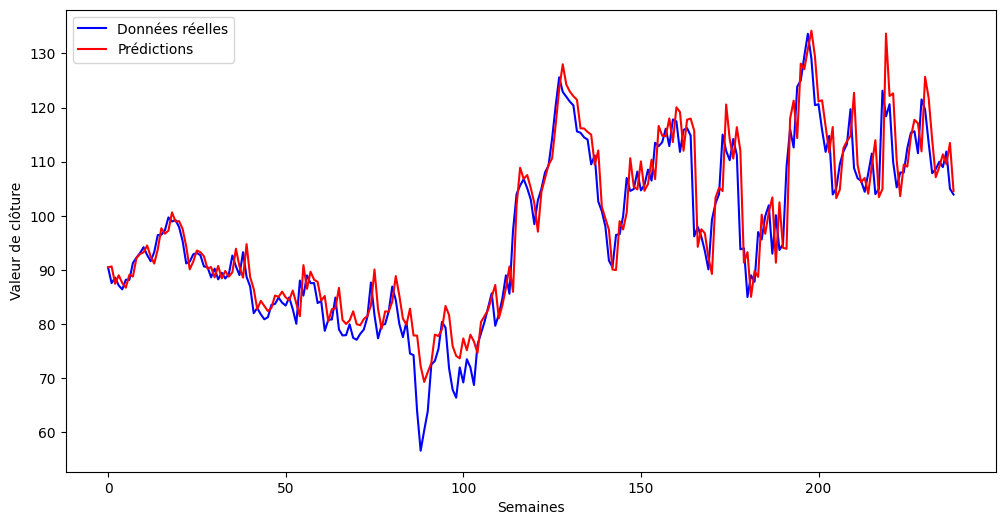

In [341]:
# Visualisation des données réelles et des prédictions
abscisse=[i for i in range(len(Y_eval))]
plt.figure(figsize=(12, 6))
plt.plot(abscisse, close_values[1000+sequence_length:1250-1], label='Données réelles', color='blue')
plt.plot(abscisse, predictions, label='Prédictions', color='red')
plt.xlabel('Semaines')
plt.ylabel('Valeur de clôture')
plt.legend()
plt.show()

En conclusion, il est observé que le modèle choisi semble donner des résultats satisfaisants, sans signes évidents de surajustement (overfitting). Les deux courbes de données présentent des similitudes, bien qu'il y ait un léger décalage temporel d'une semaine, ce dernier étant dû aux propriétés du mouvement Brownien, où la meilleure estimation du prix de clôture est souvent basée sur le prix de clôture de la semaine précédente.

Cependant, cet écart temporel peut poser problème lorsque l'on souhaite analyser et prédire les tendances du marché, car il peut ne pas refléter de manière précise les évolutions du marché à court terme. Pour améliorer ces résultats, il serait pertinent d'explorer des ajustements de paramètres, notamment en réduisant la longueur des séries temporelles de 10 à 5 semaines (le but serai de réduire le poids de la dernière composante). Cette modification pourrait potentiellement conduire à des prédictions plus pertinentes et plus conformes aux tendances récentes du marché.

ENGLISH TRANSLATION : 
In conclusion, it is observed that the chosen model appears to yield satisfactory results without clear signs of overfitting. The two data curves exhibit similarities, albeit with a slight temporal shift of one week. This shift can be attributed to the properties of Brownian motion, where the best estimation of closing prices often relies on the previous week's closing price.

However, this temporal gap can present challenges when analyzing and predicting market trends, as it may not accurately reflect short-term market developments. To enhance these results, it would be advisable to explore parameter adjustments, including reducing the length of the time series from 10 to 5 weeks (the objective is to reduce the weight of the last component). This modification could potentially lead to more relevant predictions that align better with recent market trends.